In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as TF
import torch.nn.init as init

# Image preprocessing
from skimage.transform import resize

# Model and training utilities
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

# Setup
import logging

import os
import csv
from pathlib import Path

import pickle 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dir = Path("/work3/kvabo/PKGCTORG/newCT")

In [3]:
class CTOrganSegDataset(Dataset):
    def __init__(self, case_numbers, dir, filteredData=Path("kidneySlices.pkl")):
        self.case_numbers = case_numbers
        self.data_dir = Path(dir)
        self.resize_size = (256, 256)

        # Load precomputed slice data
        with open(filteredData, 'rb') as f:
            all_slice_data = pickle.load(f)

        # Keep only slices for relevant cases
        self.slice_data = [
            (case_number, slice_idx)
            for (case_number, slice_idx) in all_slice_data
            if case_number in self.case_numbers
        ]

        # Preload volume and label paths
        self.volumePaths = {
            case_number: self.data_dir / f"volume-{case_number}.npy"
            for case_number in self.case_numbers
        }
        self.labelPaths = {
            case_number: self.data_dir / f"labels-{case_number}.npy"
            for case_number in self.case_numbers
        }

    def __len__(self):
        return len(self.slice_data)

    def __getitem__(self, idx):
        case_number, slice_idx = self.slice_data[idx]
        volume = np.load(self.volumePaths[case_number])
        label = np.load(self.labelPaths[case_number])

        volume_slice = volume[:, :, slice_idx]
        label_slice = label[:, :, slice_idx]

        # Resize CT slice
        volume_pil = Image.fromarray(volume_slice).convert("F")
        volume_resized = TF.resize(volume_pil, self.resize_size)
        volume_array = np.array(volume_resized, dtype=np.float32)

        # Determine which class to segment
        target_class = 4
        binary_mask = (label_slice == target_class).astype(np.uint8)

        # Resize mask
        mask_pil = Image.fromarray(binary_mask * 255)
        mask_resized = TF.resize(mask_pil, self.resize_size)
        mask_array = np.array(mask_resized) / 255.0

        # Stack input and mask
        X = np.stack([volume_array, mask_array], axis=0).astype(np.float32)

        return torch.tensor(X), case_number, slice_idx


In [4]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc_conv0 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2)  # 32 -> 16

        # Bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # Decoder
        self.upsample0 = nn.Upsample(scale_factor=2)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64 + 64, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64 + 64, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64 + 64, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64 + 64, 64, 3, padding=1)

        # Final output
        self.final_conv = nn.Conv2d(64, out_channels, 1)  # [B, 64, 256, 256] -> [B, 4, 256, 256]


    def forward(self, x):
        # Encoder
        s0 = F.relu(self.enc_conv0(x))   # [B, 64, 256, 256]
        e0 = self.pool0(s0)              # [B, 64, 128, 128]
        s1 = F.relu(self.enc_conv1(e0))  # [B, 64, 128, 128]
        e1 = self.pool1(s1)              # [B, 64, 64, 64]
        s2 = F.relu(self.enc_conv2(e1))  # [B, 64, 64, 64]
        e2 = self.pool2(s2)              # [B, 64, 32, 32]
        s3 = F.relu(self.enc_conv3(e2))  # [B, 64, 32, 32]
        e3 = self.pool3(s3)              # [B, 64, 16, 16]

        # Bottleneck
        b = F.relu(self.bottleneck_conv(e3))  # [B, 64, 16, 16]

        # Decoder
        d0 = F.relu(self.dec_conv0(torch.cat([self.upsample0(b), s3], dim=1)))  # [B, 64, 32, 32]
        d1 = F.relu(self.dec_conv1(torch.cat([self.upsample1(d0), s2], dim=1))) # [B, 64, 64, 64]
        d2 = F.relu(self.dec_conv2(torch.cat([self.upsample2(d1), s1], dim=1))) # [B, 64, 128, 128]
        d3 = F.relu(self.dec_conv3(torch.cat([self.upsample3(d2), s0], dim=1))) # [B, 64, 256, 256]

        out = self.final_conv(d3)  # [B, 4, 256, 256]
        return out

# He initialization function
def init_he(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)



model = UNet()

In [5]:
allCases = list(range(140))

# Create datasets
allDataset = CTOrganSegDataset(allCases, dir)

batch_size = 10

# Create DataLoaders
allLoader = DataLoader(allDataset, batch_size=batch_size, shuffle=False)

In [11]:
diceLoss = smp.losses.DiceLoss(mode='binary', from_logits=False, eps=1e-7, smooth = 1)

In [ ]:
model = UNet() 
model_path = "qcKidneyDsc0.8.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.to(device)
model.eval()

dscBone = []

with torch.no_grad():
    for batch_idx, (X, _, _) in enumerate(allLoader):

        inputs = X[:, 0:1, :, :].to(device)         # CT slice [B, 1, 256, 256]
        labels = X[:, 1:, :, :].to(device)          # Ground truth masks [B, 4, 256, 256]

        outputs = torch.sigmoid(model(inputs))
        loss = diceLoss(labels, outputs)
        print(f"Sanity Dice Loss (GT vs GT): {diceLoss(labels, labels):.10f}")
        print(f"Predicted vs Ground Truth Dice Loss: {loss:.10f}")

        probs = outputs  # Make sure 'probs' is defined
        preds_bin = (probs > 0.5).float().cpu()  # Move to CPU directly

        for i in range(min(3, inputs.shape[0])):
            img = inputs[i, 0].detach().cpu().numpy()
            pred_mask = preds_bin[i, 0].numpy()
            gt_mask = labels[i, 0].detach().cpu().numpy()

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(img, cmap='gray')
            axs[0].set_title('CT Slice')
            axs[0].axis('off')

            dsc_pred = 1 - diceLoss(preds_bin[i:i+1].to(device), labels[i:i+1]).item()
            axs[1].imshow(pred_mask, cmap='gray')
            axs[1].set_title(f'Prediction\nDSC: {dsc_pred:.3f}')
            axs[1].axis('off')

            axs[2].imshow(gt_mask, cmap='gray')
            axs[2].set_title('Ground Truth')
            axs[2].axis('off')

            plt.tight_layout()
            plt.show()
            plt.close(fig)  # <--- vigtig!

        

In [ ]:
results = []
model_name = os.path.splitext(os.path.basename(model_path))[0]
save_dir = Path("predictions") / model_name
save_dir.mkdir(parents=True, exist_ok=True)
results_csv = save_dir / "results.csv"

with torch.no_grad():
    for batch_idx, (X, case_ids, slice_indices) in enumerate(allLoader):
        inputs = X[:, 0:1, :, :].to(device)
        labels = X[:, 1:, :, :].to(device)

        outputs = torch.sigmoid(model(inputs))
        preds_bin = (outputs > 0.5).float().cpu()

        for i in range(inputs.shape[0]):
            pred_mask = preds_bin[i, 0].numpy()
            dsc_pred = 1 - diceLoss(preds_bin[i:i+1].to(device), labels[i:i+1]).item()
            plt.imshow(labels[i:i+1].cpu().squeeze().squeeze())
            case_id = case_ids[i].item()
            slice_idx = int(slice_indices[i])
            pred_filename = f"{case_id}_slice_{slice_idx}_pred.npy"
            pred_path = save_dir / pred_filename
            np.save(pred_path, pred_mask)

            results.append({
                "case": case_id,
                "slice": slice_idx,
                "model": model_name,
                "dsc": round(dsc_pred, 5),
                "prediction_file": pred_filename
            })

# Save results CSV
with open(results_csv, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=["case", "slice", "model", "dsc", "prediction_file"])
    writer.writeheader()
    writer.writerows(results)

print(f"Saved predictions to {save_dir}")
print(f"Saved CSV summary to {results_csv}")

In [97]:
qcData = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc0.5Continued/results.csv")
case_number = qcData.case
slice_idx = qcData.slice
dsc = qcData.dsc

In [98]:
np.mean(dsc)

0.4277546610409871

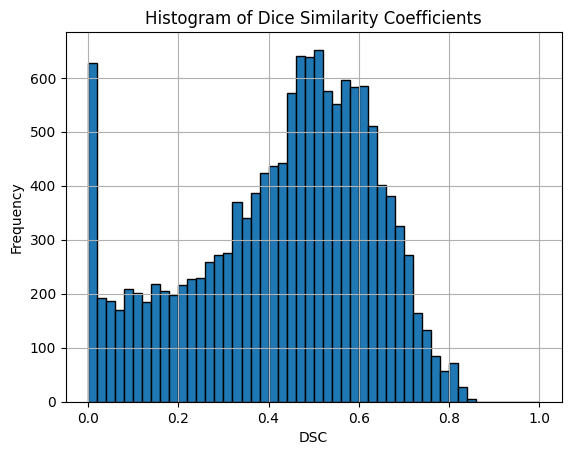

In [99]:
plt.hist(dsc, bins=50, range=(0, 1), edgecolor='black')
plt.xlabel('DSC')
plt.ylabel('Frequency')
plt.title('Histogram of Dice Similarity Coefficients')
plt.grid(True)
plt.show()

0.8060959984399375


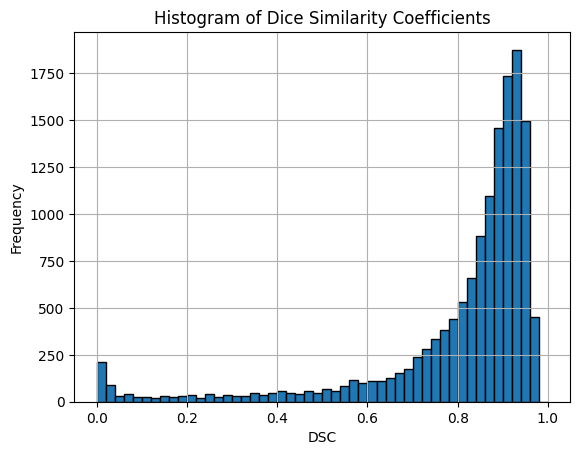

In [88]:
qcData = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc0.1Continued/results.csv")
case_number = qcData.case
slice_idx = qcData.slice
dsc = qcData.dsc
plt.hist(dsc, bins=50, range=(0, 1), edgecolor='black')
print(np.mean(dsc))
plt.xlabel('DSC')
plt.ylabel('Frequency')
plt.title('Histogram of Dice Similarity Coefficients')
plt.grid(True)
plt.show()

0.657923852645015


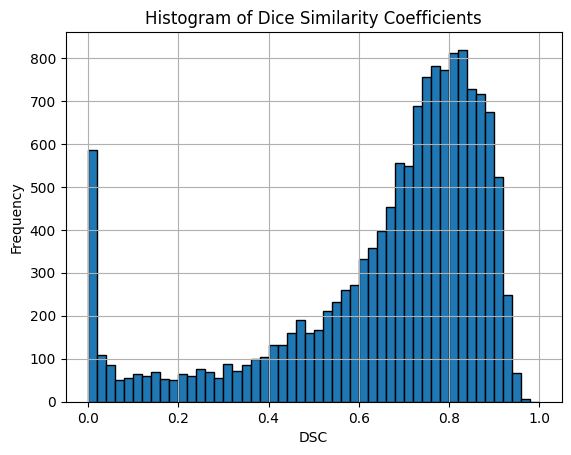

In [91]:
qcData = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc0.3Continued/results.csv")
case_number = qcData.case
slice_idx = qcData.slice
dsc = qcData.dsc
plt.hist(dsc, bins=50, range=(0, 1), edgecolor='black')
print(np.mean(dsc))
plt.xlabel('DSC')
plt.ylabel('Frequency')
plt.title('Histogram of Dice Similarity Coefficients')
plt.grid(True)
plt.show()

Missing data for model: qcLiverDsc0.2
Mean DSC for qcLiverDsc0.3: 0.3542
Mean DSC for qcLiverDsc0.4: 0.3569
Mean DSC for qcLiverDsc0.5: 0.4581
Mean DSC for qcLiverDsc0.6: 0.5455
Mean DSC for qcLiverDsc0.7: 0.6169
Mean DSC for qcLiverDsc0.8: 0.6954
Mean DSC for qcLiverDsc0.9: 0.8014
Mean DSC for qcLiverDsc1.0: 0.8457


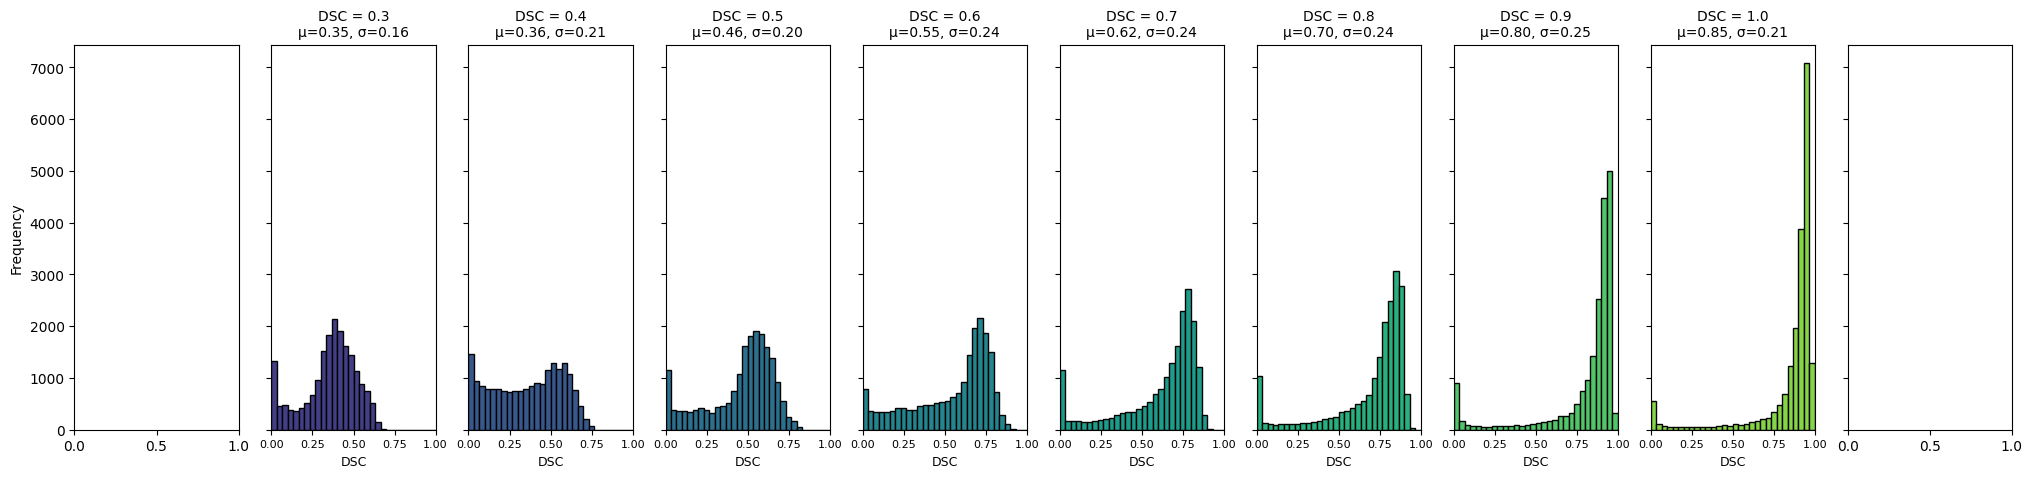

<Figure size 1000x600 with 0 Axes>

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Range of DSC thresholds
dsc_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9,1.0]

n_cols = len(dsc_thresholds) +1
fig, axs = plt.subplots(1, n_cols, figsize=(2.5 * n_cols, 5), sharey=True)

colors = sns.color_palette("viridis", n_cols)
# Prepare plot
plt.figure(figsize=(10, 6))

# Collect DSC data and labels
all_dsc_values = []
all_labels = []

# Loop through thresholds
for i, dsc in enumerate(dsc_thresholds):
    model_name = f"qcLiverDsc{dsc:.1f}"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if csv_path.exists():
        data = pd.read_csv(csv_path)
        dsc_values = data["dsc"]
        all_dsc_values.append(dsc_values)
        all_labels.append(f"DSC {dsc:.1f}")
        print(f"Mean DSC for {model_name}: {np.mean(dsc_values):.4f}")

        mean_dsc = np.mean(dsc_values)
        std_dsc = np.std(dsc_values)
        
        axs[i].hist(dsc_values, bins=30, range=(0, 1), color=colors[i], edgecolor='black')
        axs[i].set_title(f"DSC = {dsc:.1f}\nμ={mean_dsc:.2f}, σ={std_dsc:.2f}", fontsize=10)
        axs[i].set_xlabel("DSC", fontsize=9)
        axs[i].set_xlim(0, 1)
        axs[i].tick_params(axis='x', labelsize=8)
        axs[i].tick_params(axis='y', labelsize=8)
    else:
        print(f"Missing data for model: {model_name}")
    
    
axs[0].set_ylabel("Frequency", fontsize=10)
plt.suptitle("Evolution of DSC Predictions as More Data is Added", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Missing data for model: qcLiverDsc0.1
Missing data for model: qcLiverDsc0.2
Mean DSC for qcLiverDsc0.3: 0.3542
Mean DSC for qcLiverDsc0.4: 0.3569
Mean DSC for qcLiverDsc0.5: 0.4581
Mean DSC for qcLiverDsc0.6: 0.5455
Mean DSC for qcLiverDsc0.7: 0.6169
Mean DSC for qcLiverDsc0.8: 0.6954
Mean DSC for qcLiverDsc0.9: 0.8014
Mean DSC for qcLiverDsc1.0: 0.8457


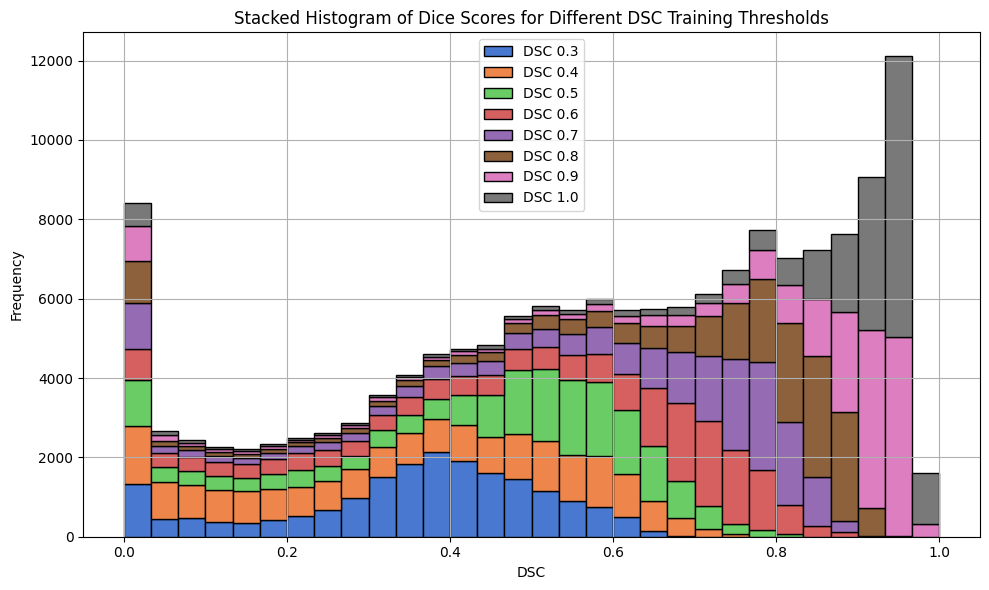

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Range of DSC thresholds
dsc_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Prepare plot
plt.figure(figsize=(10, 6))

# Collect DSC data and labels
all_dsc_values = []
all_labels = []

# Loop through thresholds
for dsc in dsc_thresholds:
    model_name = f"qcLiverDsc{dsc:.1f}"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if csv_path.exists():
        data = pd.read_csv(csv_path)
        dsc_values = data["dsc"]
        all_dsc_values.append(dsc_values)
        all_labels.append(f"DSC {dsc:.1f}")
        print(f"Mean DSC for {model_name}: {np.mean(dsc_values):.4f}")
    else:
        print(f"Missing data for model: {model_name}")
colors = sns.color_palette("muted", 8)

# Plot stacked histogram
plt.hist(all_dsc_values, bins=30, range=(0, 1), stacked=True, label=all_labels, edgecolor='black', color = colors)

# Plot formatting
plt.xlabel("DSC")
plt.ylabel("Frequency")
plt.title("Stacked Histogram of Dice Scores for Different DSC Training Thresholds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

0.845689186243767


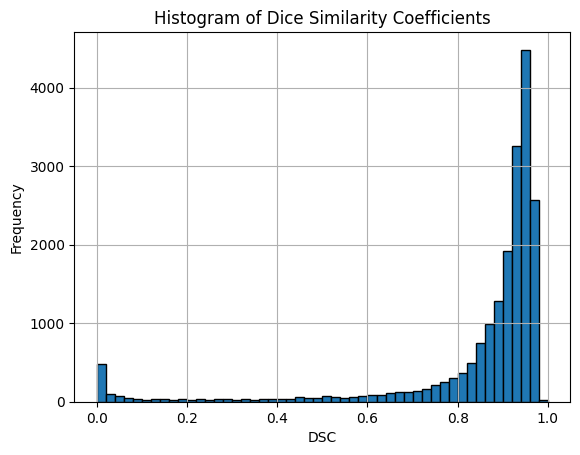

In [6]:
qcData = pd.read_csv("/work3/kvabo/predictions/qcLiverDsc1.0/results.csv")
case_number = qcData.case
slice_idx = qcData.slice
dsc = qcData.dsc
plt.hist(dsc, bins=50, range=(0, 1), edgecolor='black')
print(np.mean(dsc))
plt.xlabel('DSC')
plt.ylabel('Frequency')
plt.title('Histogram of Dice Similarity Coefficients')
plt.grid(True)
plt.show()

In [ ]:
dsc = 0.5
model_name = f"qcKidneyDsc{dsc}Continued"
data = pd.read_csv(Path(f"/work3/kvabo/predictions/{model_name}/results.csv"))
case_number = data.case
slice_idx = data.slice

dsc_values = data["dsc"]
plt.hist(dsc_values, bins=50, range=(0, 1), alpha=0.5, label=f"{1-dsc}", edgecolor='black')

# Plot formatting
plt.xlabel("DSC")
plt.ylabel("Frequency")
plt.title("Histogram of Dice Scores for Different DSC Training Thresholds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

0.97906
14102
Mean DSC for qcKidneyDsc0.1Continued: 0.8061
14102
Mean DSC for qcKidneyDsc0.2Continued: 0.7397
14102
Mean DSC for qcKidneyDsc0.3Continued: 0.6579
14102
Mean DSC for qcKidneyDsc0.4Continued: 0.5704
14102
Mean DSC for qcKidneyDsc0.5Continued: 0.4278
14102
Mean DSC for qcKidneyDsc0.6: 0.3752
14102
Mean DSC for qcKidneyDsc0.7Continued: 0.2937
14102
Mean DSC for qcKidneyDsc0.8Continued: 0.1869


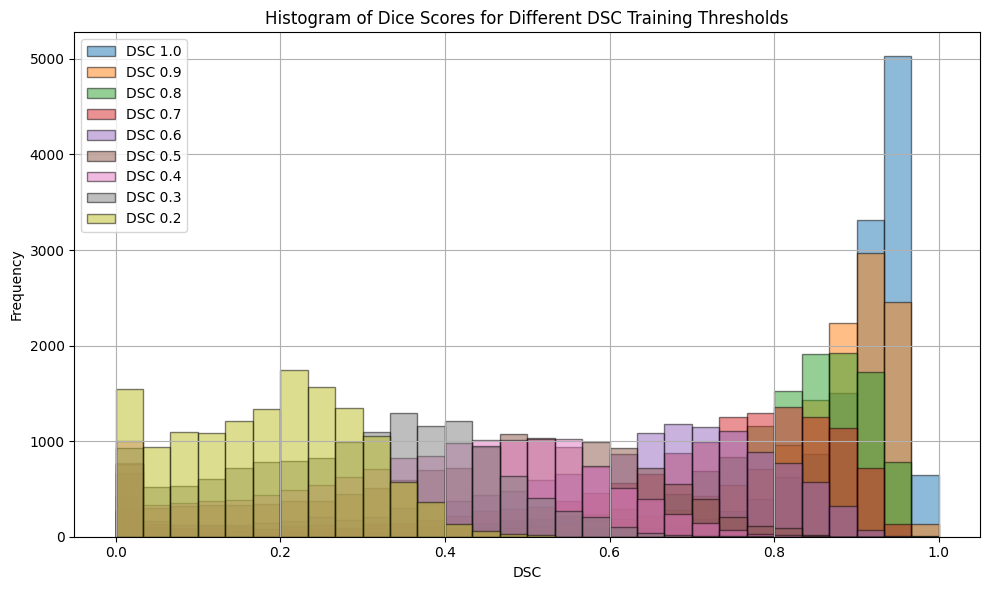

In [40]:
# Range of DSC thresholds
dsc_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Prepare plot
plt.figure(figsize=(10, 6))

data = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0_continued/results.csv")
case_number = data.case
slice_idx = data.slice

dsc_values = data["dsc"]
print(np.max(dsc_values))
plt.hist(dsc_values, bins=30, range=(0, 1), alpha=0.5, label=f"DSC {1:.1f}", edgecolor='black')


for dsc in dsc_thresholds:
    model_name = f"qcKidneyDsc{dsc:.1f}Continued"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if not csv_path.exists():
        model_name = f"qcKidneyDsc{dsc:.1f}"
        csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")

    data = pd.read_csv(csv_path)
    dsc_values = data["dsc"]
    print(len(dsc_values))
    
    plt.hist(dsc_values, bins=30, range=(0, 1), alpha=0.5, label=f"DSC {1-dsc:.1f}", edgecolor='black')

    print(f"Mean DSC for {model_name}: {np.mean(dsc_values):.4f}")



# Plot formatting
plt.xlabel("DSC")
plt.ylabel("Frequency")
plt.title("Histogram of Dice Scores for Different DSC Training Thresholds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

0.97906
Mean DSC for qcKidneyDsc0.1Continued: 0.8061
Mean DSC for qcKidneyDsc0.2Continued: 0.7397
Mean DSC for qcKidneyDsc0.3Continued: 0.6579
Mean DSC for qcKidneyDsc0.4Continued: 0.5704
Mean DSC for qcKidneyDsc0.5Continued: 0.4278
Mean DSC for qcKidneyDsc0.6: 0.3752
Mean DSC for qcKidneyDsc0.7Continued: 0.2937
Mean DSC for qcKidneyDsc0.8Continued: 0.1869
Mean DSC for qcKidneyDsc0.9Continued: 0.0077


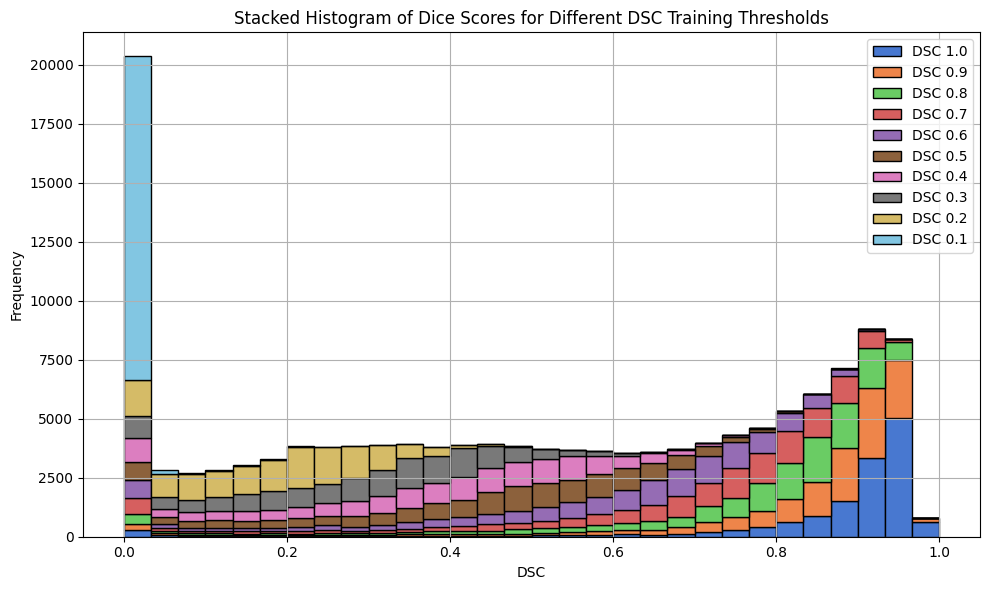

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Range of DSC thresholds
dsc_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]

# Prepare plot
plt.figure(figsize=(10, 6))

# Collect DSC data and labels
all_dsc_values = []
all_labels = []

# Base model (DSC = 1.0)
base_data = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0_continued/results.csv")
base_dsc_values = base_data["dsc"]
all_dsc_values.append(base_dsc_values)
all_labels.append("DSC 1.0")  # 1.0 threshold → 0.0 difference

print(np.max(base_dsc_values))

# Loop through thresholds
for dsc in dsc_thresholds:
    model_name = f"qcKidneyDsc{dsc:.1f}Continued"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if not csv_path.exists():
        model_name = f"qcKidneyDsc{dsc:.1f}"
        csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if csv_path.exists():
        data = pd.read_csv(csv_path)
        dsc_values = data["dsc"]
        all_dsc_values.append(dsc_values)
        all_labels.append(f"DSC {1 - dsc:.1f}")
        print(f"Mean DSC for {model_name}: {np.mean(dsc_values):.4f}")
    else:
        print(f"Missing data for model: {model_name}")
colors = sns.color_palette("muted", len(dsc_thresholds) + 1)

# Plot stacked histogram
plt.hist(all_dsc_values, bins=30, range=(0, 1), stacked=True, label=all_labels, edgecolor='black', color = colors)

# Plot formatting
plt.xlabel("DSC")
plt.ylabel("Frequency")
plt.title("Stacked Histogram of Dice Scores for Different DSC Training Thresholds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


0.97906
Mean DSC for qcKidneyDsc0.1Continued: 0.8061
Mean DSC for qcKidneyDsc0.2Continued: 0.7397
Mean DSC for qcKidneyDsc0.3Continued: 0.6579
Mean DSC for qcKidneyDsc0.4Continued: 0.5704
Mean DSC for qcKidneyDsc0.5Continued: 0.4278
Mean DSC for qcKidneyDsc0.6: 0.3752
Mean DSC for qcKidneyDsc0.7Continued: 0.2937
Mean DSC for qcKidneyDsc0.8Continued: 0.1869


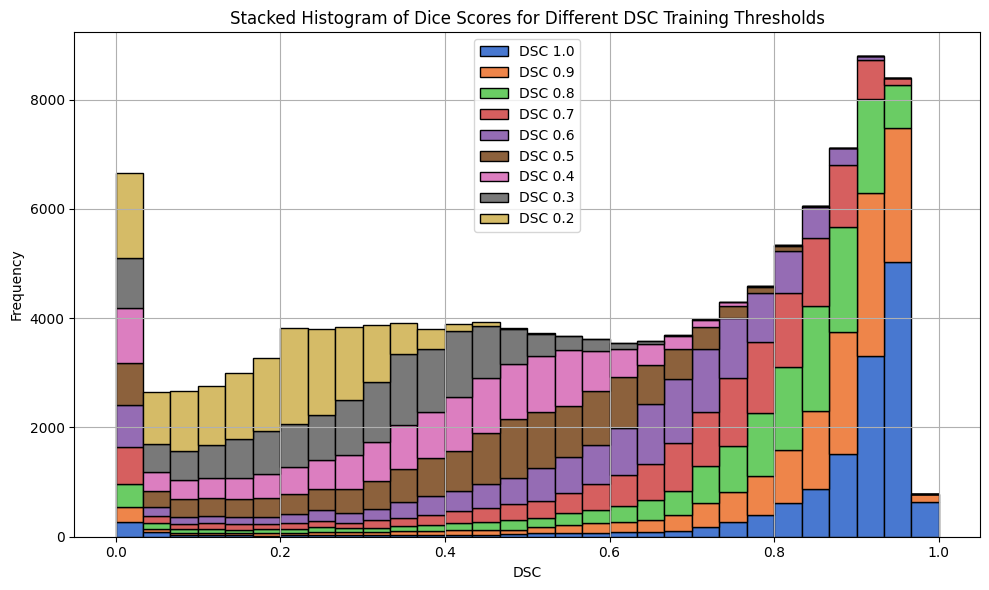

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Range of DSC thresholds
dsc_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Prepare plot
plt.figure(figsize=(10, 6))

# Collect DSC data and labels
all_dsc_values = []
all_labels = []

# Base model (DSC = 1.0)
base_data = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0_continued/results.csv")
base_dsc_values = base_data["dsc"]
all_dsc_values.append(base_dsc_values)
all_labels.append("DSC 1.0")  # 1.0 threshold → 0.0 difference

print(np.max(base_dsc_values))

# Loop through thresholds
for dsc in dsc_thresholds:
    model_name = f"qcKidneyDsc{dsc:.1f}Continued"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if not csv_path.exists():
        model_name = f"qcKidneyDsc{dsc:.1f}"
        csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if csv_path.exists():
        data = pd.read_csv(csv_path)
        dsc_values = data["dsc"]
        all_dsc_values.append(dsc_values)
        all_labels.append(f"DSC {1 - dsc:.1f}")
        print(f"Mean DSC for {model_name}: {np.mean(dsc_values):.4f}")
    else:
        print(f"Missing data for model: {model_name}")
colors = sns.color_palette("muted", len(dsc_thresholds) + 1)

# Plot stacked histogram
plt.hist(all_dsc_values, bins=30, range=(0, 1), stacked=True, label=all_labels, edgecolor='black', color = colors)

# Plot formatting
plt.xlabel("DSC")
plt.ylabel("Frequency")
plt.title("Stacked Histogram of Dice Scores for Different DSC Training Thresholds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


0.97906
Mean DSC for qcKidneyDsc0.1Continued: 0.8183
Mean DSC for qcKidneyDsc0.2Continued: 0.7397
Mean DSC for qcKidneyDsc0.3Continued: 0.6491
Mean DSC for qcKidneyDsc0.4Continued: 0.5466
Mean DSC for qcKidneyDsc0.5Continued: 0.4000
Mean DSC for qcKidneyDsc0.6: 0.3545
Mean DSC for qcKidneyDsc0.7Continued: 0.2907
Mean DSC for qcKidneyDsc0.8Continued: 0.1881


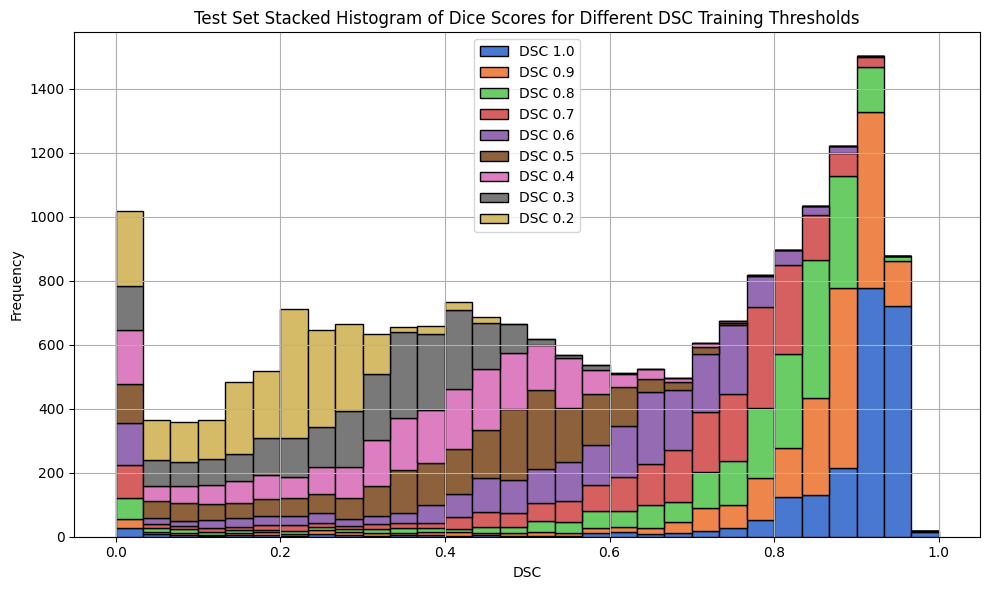

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Range of DSC thresholds
dsc_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Prepare plot
plt.figure(figsize=(10, 6))

# Collect DSC data and labels
all_dsc_values = []
all_labels = []

# Base model (DSC = 1.0)
data = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0_continued/results.csv")
data_filtered = data[data["case"] <= 20]
dsc_values = data_filtered["dsc"]
all_dsc_values.append(dsc_values)
all_labels.append("DSC 1.0")  # 1.0 threshold → 0.0 difference

print(np.max(base_dsc_values))

# Loop through thresholds
for dsc in dsc_thresholds:
    model_name = f"qcKidneyDsc{dsc:.1f}Continued"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if not csv_path.exists():
        model_name = f"qcKidneyDsc{dsc:.1f}"
        csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if csv_path.exists():
        data = pd.read_csv(csv_path)
        data_filtered = data[data["case"] <= 20]
        dsc_values = data_filtered["dsc"]
        all_dsc_values.append(dsc_values)
        all_labels.append(f"DSC {1 - dsc:.1f}")
        print(f"Mean DSC for {model_name}: {np.mean(dsc_values):.4f}")
    else:
        print(f"Missing data for model: {model_name}")
colors = sns.color_palette("muted", len(dsc_thresholds) + 1)

# Plot stacked histogram
plt.hist(all_dsc_values, bins=30, range=(0, 1), stacked=True, label=all_labels, edgecolor='black', color = colors)

# Plot formatting
plt.xlabel("DSC")
plt.ylabel("Frequency")
plt.title("Test Set Stacked Histogram of Dice Scores for Different DSC Training Thresholds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


0.97906
Mean DSC for qcKidneyDsc0.1Continued: 0.8038
Mean DSC for qcKidneyDsc0.2Continued: 0.7397
Mean DSC for qcKidneyDsc0.3Continued: 0.6596
Mean DSC for qcKidneyDsc0.4Continued: 0.5749
Mean DSC for qcKidneyDsc0.5Continued: 0.4330
Mean DSC for qcKidneyDsc0.6: 0.3791
Mean DSC for qcKidneyDsc0.7Continued: 0.2943
Mean DSC for qcKidneyDsc0.8Continued: 0.1866


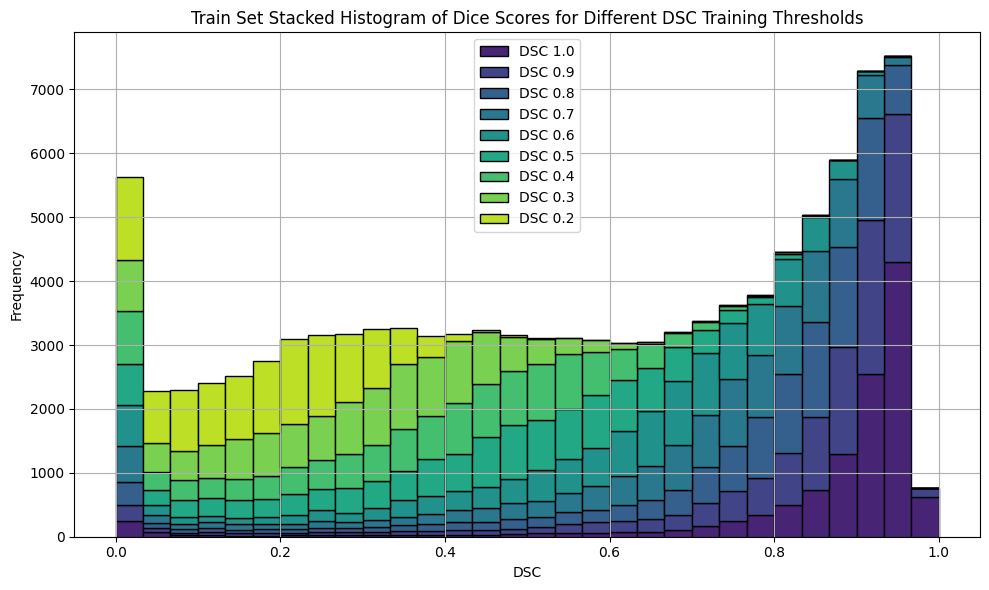

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Range of DSC thresholds
dsc_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Prepare plot
plt.figure(figsize=(10, 6))

# Collect DSC data and labels
all_dsc_values = []
all_labels = []

# Base model (DSC = 1.0)
data = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0_continued/results.csv")
data_filtered = data[data["case"] > 20]
dsc_values = data_filtered["dsc"]
all_dsc_values.append(dsc_values)
all_labels.append("DSC 1.0")  # 1.0 threshold → 0.0 difference

print(np.max(base_dsc_values))

# Loop through thresholds
for dsc in dsc_thresholds:
    model_name = f"qcKidneyDsc{dsc:.1f}Continued"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if not csv_path.exists():
        model_name = f"qcKidneyDsc{dsc:.1f}"
        csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if csv_path.exists():
        data = pd.read_csv(csv_path)
        data_filtered = data[data["case"] > 20]
        dsc_values = data_filtered["dsc"]
        all_dsc_values.append(dsc_values)
        all_labels.append(f"DSC {1 - dsc:.1f}")
        print(f"Mean DSC for {model_name}: {np.mean(dsc_values):.4f}")
    else:
        print(f"Missing data for model: {model_name}")
colors = sns.color_palette("viridis", len(dsc_thresholds) + 1)

# Plot stacked histogram
plt.hist(all_dsc_values, bins=30, range=(0, 1), stacked=True, label=all_labels, edgecolor='black', color = colors)

# Plot formatting
plt.xlabel("DSC")
plt.ylabel("Frequency")
plt.title("Train Set Stacked Histogram of Dice Scores for Different DSC Training Thresholds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


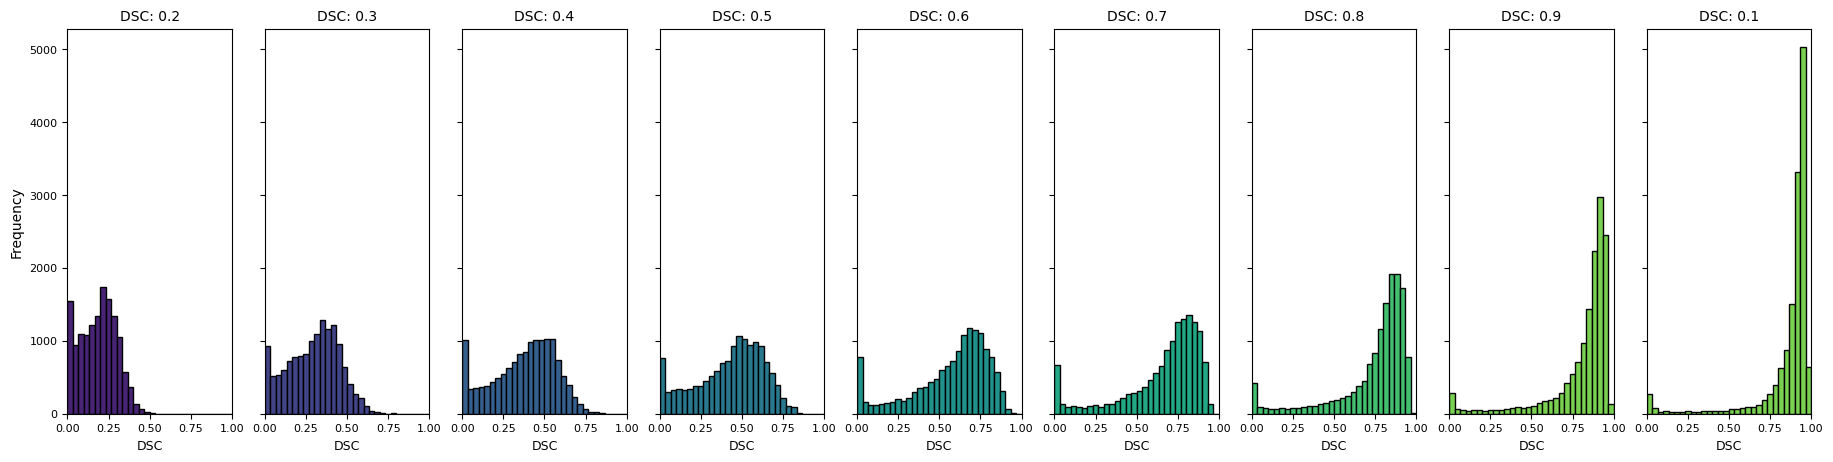

<Figure size 1000x600 with 0 Axes>

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Range of DSC thresholds
dsc_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]

n_cols = len(dsc_thresholds) +1
fig, axs = plt.subplots(1, n_cols, figsize=(2.5 * n_cols, 5), sharey=True)

colors = sns.color_palette("viridis", len(dsc_thresholds) + 1)
# Prepare plot
plt.figure(figsize=(10, 6))




# Loop through thresholds
for i, dsc in enumerate(dsc_thresholds):
    model_name = f"qcKidneyDsc{1-dsc:.1f}Continued"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if not csv_path.exists():
        model_name = f"qcKidneyDsc{1-dsc:.1f}"
        csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if csv_path.exists():
        data = pd.read_csv(csv_path)
        dsc_values = data["dsc"]
    else:
        print(f"Missing data for model: {model_name}")
    
    axs[i].hist(dsc_values, bins=30, range=(0, 1), color=colors[i], edgecolor='black')
    axs[i].set_title(f"DSC: {dsc:.1f}", fontsize=10)
    axs[i].set_xlabel("DSC", fontsize=9)
    axs[i].set_xlim(0, 1)
    axs[i].tick_params(axis='x', labelsize=8)
    axs[i].tick_params(axis='y', labelsize=8)

# Base model (DSC = 1.0)
data = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0_continued/results.csv")
dsc_values = data["dsc"]


axs[-1].hist(dsc_values, bins=30, range=(0, 1), color=colors[i], edgecolor='black')
axs[-1].set_title(f"DSC: {1- dsc:.1f}", fontsize=10)
axs[-1].set_xlabel("DSC", fontsize=9)
axs[-1].set_xlim(0, 1)
axs[-1].tick_params(axis='x', labelsize=8)
axs[-1].tick_params(axis='y', labelsize=8)

axs[0].set_ylabel("Frequency", fontsize=10)
plt.suptitle("Evolution of DSC Predictions as More Data is Added", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


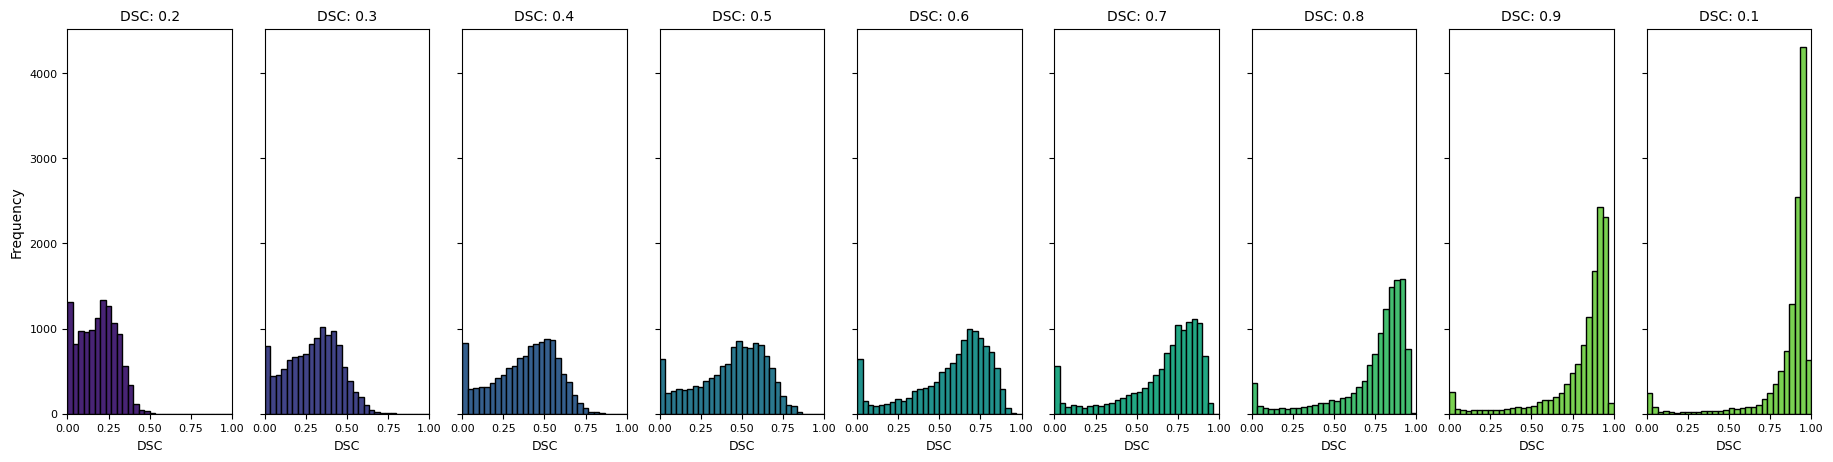

<Figure size 1000x600 with 0 Axes>

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Range of DSC thresholds
dsc_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]

n_cols = len(dsc_thresholds) +1
fig, axs = plt.subplots(1, n_cols, figsize=(2.5 * n_cols, 5), sharey=True)

colors = sns.color_palette("viridis", len(dsc_thresholds) + 1)
# Prepare plot
plt.figure(figsize=(10, 6))




# Loop through thresholds
for i, dsc in enumerate(dsc_thresholds):
    model_name = f"qcKidneyDsc{1-dsc:.1f}Continued"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if not csv_path.exists():
        model_name = f"qcKidneyDsc{1-dsc:.1f}"
        csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if csv_path.exists():
        data = pd.read_csv(csv_path)
        data_filtered = data[data["case"] > 20]
        dsc_values = data_filtered["dsc"]
    else:
        print(f"Missing data for model: {model_name}")
    
    axs[i].hist(dsc_values, bins=30, range=(0, 1), color=colors[i], edgecolor='black')
    axs[i].set_title(f"DSC: {dsc:.1f}", fontsize=10)
    axs[i].set_xlabel("DSC", fontsize=9)
    axs[i].set_xlim(0, 1)
    axs[i].tick_params(axis='x', labelsize=8)
    axs[i].tick_params(axis='y', labelsize=8)

# Base model (DSC = 1.0)
data = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0_continued/results.csv")
data_filtered = data[data["case"] > 20]
dsc_values = data_filtered["dsc"]


axs[-1].hist(dsc_values, bins=30, range=(0, 1), color=colors[i], edgecolor='black')
axs[-1].set_title(f"DSC: {1- dsc:.1f}", fontsize=10)
axs[-1].set_xlabel("DSC", fontsize=9)
axs[-1].set_xlim(0, 1)
axs[-1].tick_params(axis='x', labelsize=8)
axs[-1].tick_params(axis='y', labelsize=8)

axs[0].set_ylabel("Frequency", fontsize=10)
plt.suptitle("Evolution of DSC Predictions as More Data is Added", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


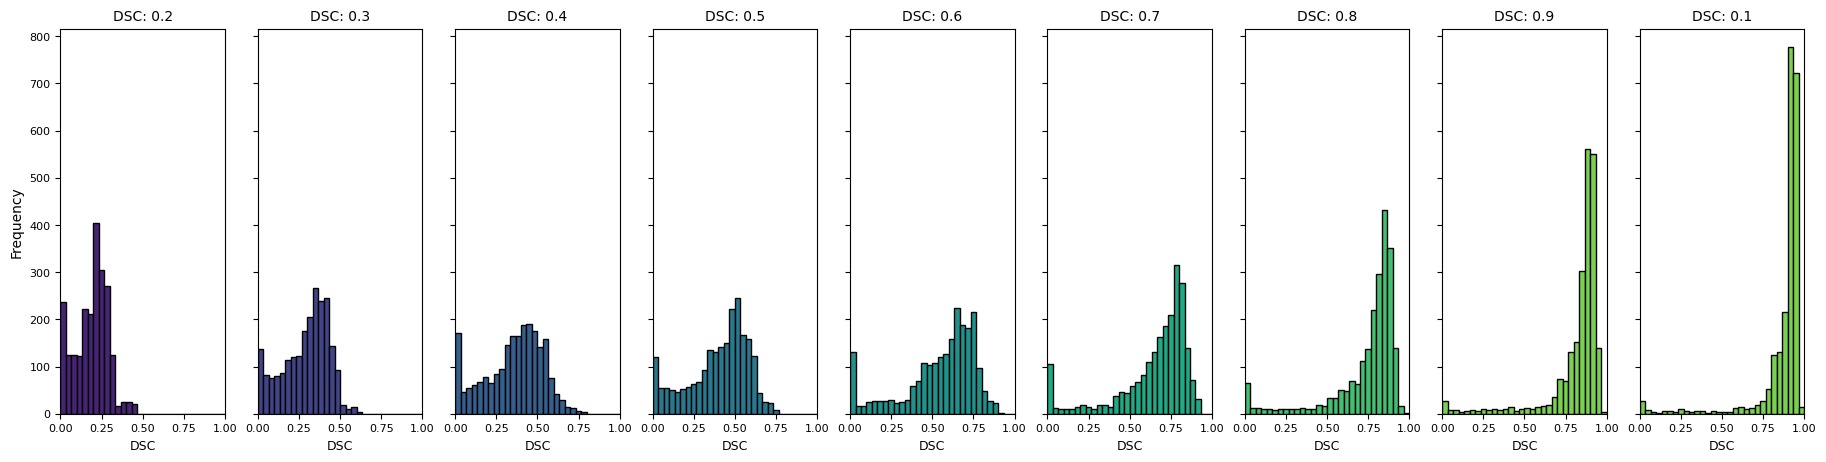

<Figure size 1000x600 with 0 Axes>

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Range of DSC thresholds
dsc_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]

n_cols = len(dsc_thresholds) +1
fig, axs = plt.subplots(1, n_cols, figsize=(2.5 * n_cols, 5), sharey=True)

colors = sns.color_palette("viridis", len(dsc_thresholds) + 1)
# Prepare plot
plt.figure(figsize=(10, 6))




# Loop through thresholds
for i, dsc in enumerate(dsc_thresholds):
    model_name = f"qcKidneyDsc{1-dsc:.1f}Continued"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if not csv_path.exists():
        model_name = f"qcKidneyDsc{1-dsc:.1f}"
        csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if csv_path.exists():
        data = pd.read_csv(csv_path)
        data_filtered = data[data["case"] <= 20]
        dsc_values = data_filtered["dsc"]
    else:
        print(f"Missing data for model: {model_name}")
    
    axs[i].hist(dsc_values, bins=30, range=(0, 1), color=colors[i], edgecolor='black')
    axs[i].set_title(f"DSC: {dsc:.1f}", fontsize=10)
    axs[i].set_xlabel("DSC", fontsize=9)
    axs[i].set_xlim(0, 1)
    axs[i].tick_params(axis='x', labelsize=8)
    axs[i].tick_params(axis='y', labelsize=8)

# Base model (DSC = 1.0)
data = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0_continued/results.csv")
data_filtered = data[data["case"] <= 20]
dsc_values = data_filtered["dsc"]


axs[-1].hist(dsc_values, bins=30, range=(0, 1), color=colors[i], edgecolor='black')
axs[-1].set_title(f"DSC: {1- dsc:.1f}", fontsize=10)
axs[-1].set_xlabel("DSC", fontsize=9)
axs[-1].set_xlim(0, 1)
axs[-1].tick_params(axis='x', labelsize=8)
axs[-1].tick_params(axis='y', labelsize=8)

axs[0].set_ylabel("Frequency", fontsize=10)
plt.suptitle("Evolution of DSC Predictions as More Data is Added", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


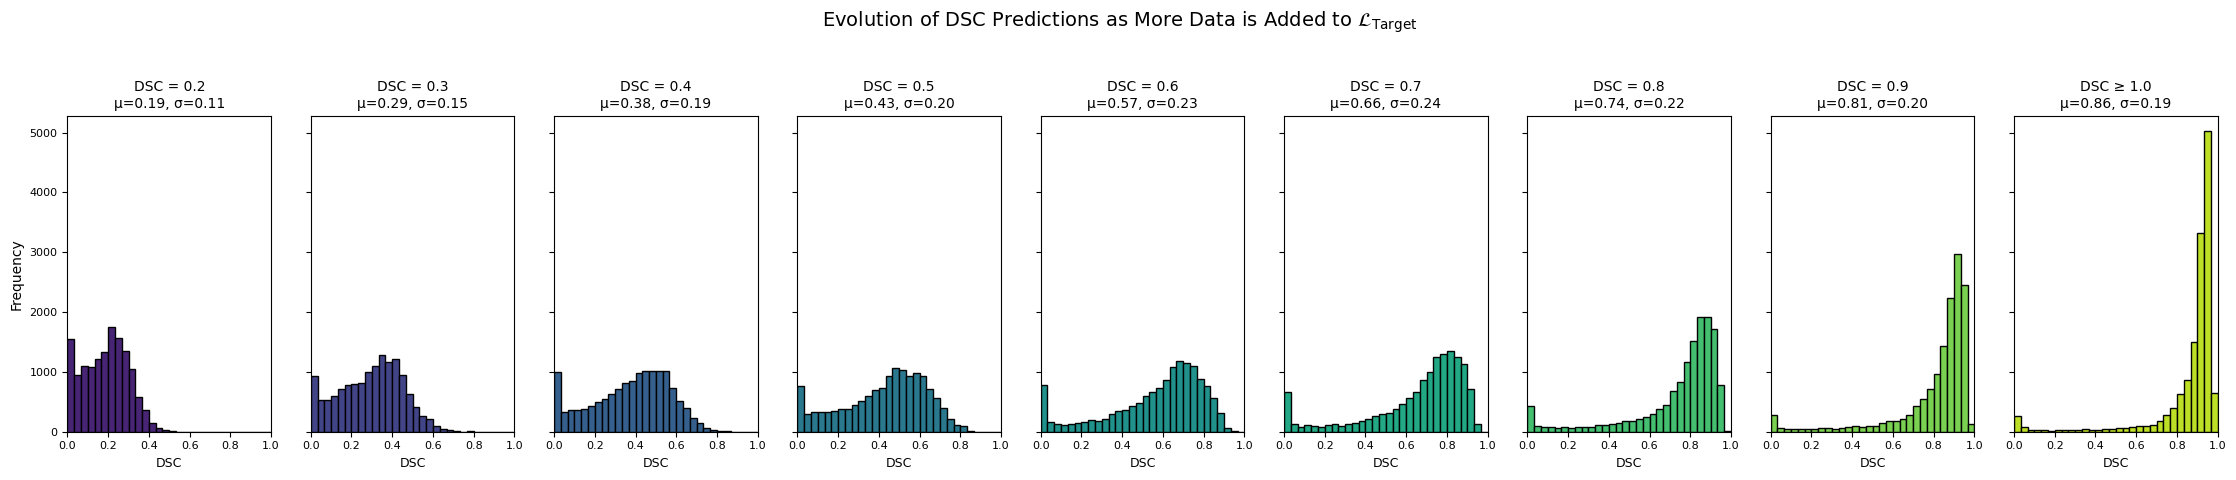

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

# Range of DSC thresholds
dsc_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

n_cols = len(dsc_thresholds) + 1
fig, axs = plt.subplots(1, n_cols, figsize=(2.5 * n_cols, 5), sharey=True)

colors = sns.color_palette("viridis", n_cols)

# Loop through thresholds and plot
for i, dsc in enumerate(dsc_thresholds):
    model_name = f"qcKidneyDsc{1 - dsc:.1f}Continued"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")

    if not csv_path.exists():
        model_name = f"qcKidneyDsc{1 - dsc:.1f}"
        csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")

    if csv_path.exists():
        data = pd.read_csv(csv_path)
        dsc_values = data["dsc"]

        mean_dsc = np.mean(dsc_values)
        std_dsc = np.std(dsc_values)

        axs[i].hist(dsc_values, bins=30, range=(0, 1), color=colors[i], edgecolor='black')
        axs[i].set_title(f"DSC = {dsc:.1f}\nμ={mean_dsc:.2f}, σ={std_dsc:.2f}", fontsize=10)
        axs[i].set_xlabel("DSC", fontsize=9)
        axs[i].set_xlim(0, 1)
        axs[i].tick_params(axis='x', labelsize=8)
        axs[i].tick_params(axis='y', labelsize=8)
    else:
        axs[i].set_visible(False)
        print(f"Missing data for model: {model_name}")

# Base model (DSC = 1.0)
data = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0_continued/results.csv")
dsc_values = data["dsc"]

mean_dsc = np.mean(dsc_values)
std_dsc = np.std(dsc_values)

axs[-1].hist(dsc_values, bins=30, range=(0, 1), color=colors[-1], edgecolor='black')
axs[-1].set_title(f"DSC ≥ 1.0\nμ={mean_dsc:.2f}, σ={std_dsc:.2f}", fontsize=10)
axs[-1].set_xlabel("DSC", fontsize=9)
axs[-1].set_xlim(0, 1)
axs[-1].tick_params(axis='x', labelsize=8)
axs[-1].tick_params(axis='y', labelsize=8)

# Shared y-axis label
axs[0].set_ylabel("Frequency", fontsize=10)

# LaTeX title with \mathcal{L}_{Target}
plt.suptitle(r"Evolution of DSC Predictions as More Data is Added to $\mathcal{L}_{\mathrm{Target}}$", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


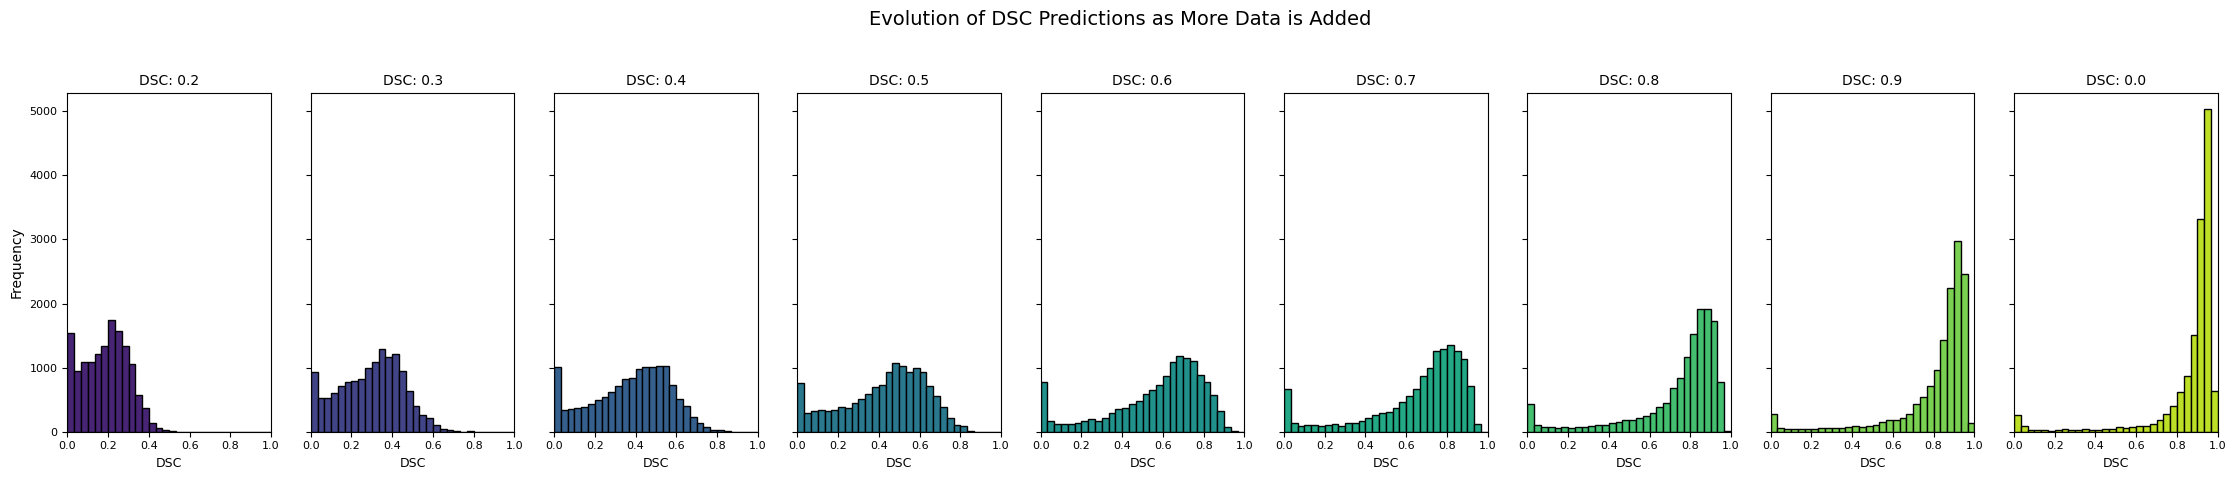

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

# DSC thresholds in reverse to show evolution (DSC 1.0 → 0.2)
dsc_thresholds = [1-d for d in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]] +[1.0] 

# Prepare figure
n_cols = len(dsc_thresholds)
fig, axs = plt.subplots(1, n_cols, figsize=(2.5 * n_cols, 5), sharey=True)

# Color palette
colors = sns.color_palette("viridis", n_cols)

# Load and plot each histogram
for i, dsc_target in enumerate(dsc_thresholds):
    dsc = 1 - dsc_target if dsc_target < 1.0 else 0.0  # Inverse used in folder naming
    model_name = f"qcKidneyDsc{1 - dsc:.1f}Continued" if dsc_target < 1.0 else "qcKidneyDsc1.0_continued"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")

    # Fallback
    if not csv_path.exists() and dsc_target < 1.0:
        model_name = f"qcKidneyDsc{1 - dsc:.1f}"
        csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
        titleDsc = dsc
    
    if csv_path.exists():
        data = pd.read_csv(csv_path)
        dsc_values = data["dsc"]

        axs[i].hist(dsc_values, bins=30, range=(0, 1), color=colors[i], edgecolor='black')
        axs[i].set_title(f"DSC: {1- dsc_target:.1f}", fontsize=10)
        axs[i].set_xlabel("DSC", fontsize=9)
        axs[i].set_xlim(0, 1)
        axs[i].tick_params(axis='x', labelsize=8)
        axs[i].tick_params(axis='y', labelsize=8)
    else:
        axs[i].set_visible(False)
        print(f"Missing: {model_name}")

# Shared y-label
axs[0].set_ylabel("Frequency", fontsize=10)
plt.suptitle("Evolution of DSC Predictions as More Data is Added", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [60]:
import seaborn as sns

colors = sns.color_palette("pastel", len(dsc_thresholds) + 1)


In [56]:
colors

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098)]

2229
Mean DSC for qcKidneyDsc0.1Continued: 0.8183
2229
Mean DSC for qcKidneyDsc0.2Continued: 0.7397
2229
Mean DSC for qcKidneyDsc0.3Continued: 0.6491
2229
Mean DSC for qcKidneyDsc0.4Continued: 0.5466
2229
Mean DSC for qcKidneyDsc0.5Continued: 0.4000
2229
Mean DSC for qcKidneyDsc0.6: 0.3545
2229
Mean DSC for qcKidneyDsc0.7Continued: 0.2907
2229
Mean DSC for qcKidneyDsc0.8Continued: 0.1881


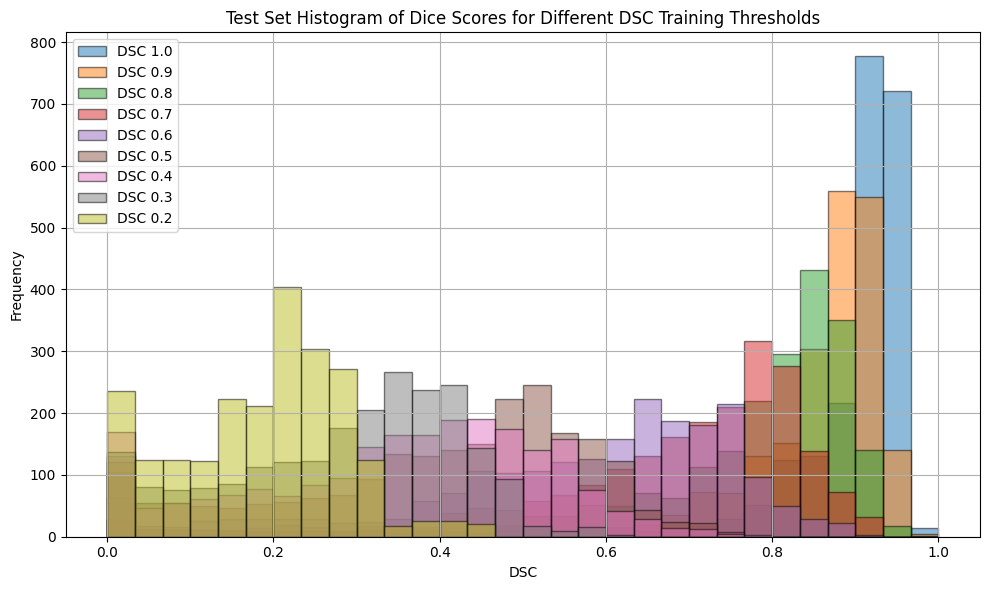

In [43]:
# Range of DSC thresholds
dsc_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Prepare plot
plt.figure(figsize=(10, 6))

data = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0_continued/results.csv")
case_number = data.case
slice_idx = data.slice

data_filtered = data[data["case"] <= 20]
dsc_values = data_filtered["dsc"]
plt.hist(dsc_values, bins=30, range=(0, 1), alpha=0.5, label=f"DSC {1:.1f}", edgecolor='black')

for dsc in dsc_thresholds:
    model_name = f"qcKidneyDsc{dsc:.1f}Continued"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if not csv_path.exists():
        model_name = f"qcKidneyDsc{dsc:.1f}"
        csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
        
    data = pd.read_csv(csv_path)
    data_filtered = data[data["case"] <= 20]
    dsc_values = data_filtered["dsc"]
    print(len(dsc_values))
    #data = pd.read_csv(csv_path)
    #dsc_values = data['dsc']
    
    plt.hist(dsc_values, bins=30, range=(0, 1), alpha=0.5, label=f"DSC {1-dsc:.1f}", edgecolor='black')

    print(f"Mean DSC for {model_name}: {np.mean(dsc_values):.4f}")


# Plot formatting
plt.xlabel("DSC")
plt.ylabel("Frequency")
plt.title("Test Set Histogram of Dice Scores for Different DSC Training Thresholds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Mean DSC for qcKidneyDsc0.1Continued: 0.8038
Mean DSC for qcKidneyDsc0.2Continued: 0.7397
Mean DSC for qcKidneyDsc0.3Continued: 0.6596
Mean DSC for qcKidneyDsc0.4Continued: 0.5749
Mean DSC for qcKidneyDsc0.5Continued: 0.4330
Mean DSC for qcKidneyDsc0.6: 0.3791
Mean DSC for qcKidneyDsc0.7Continued: 0.2943
Mean DSC for qcKidneyDsc0.8Continued: 0.1866


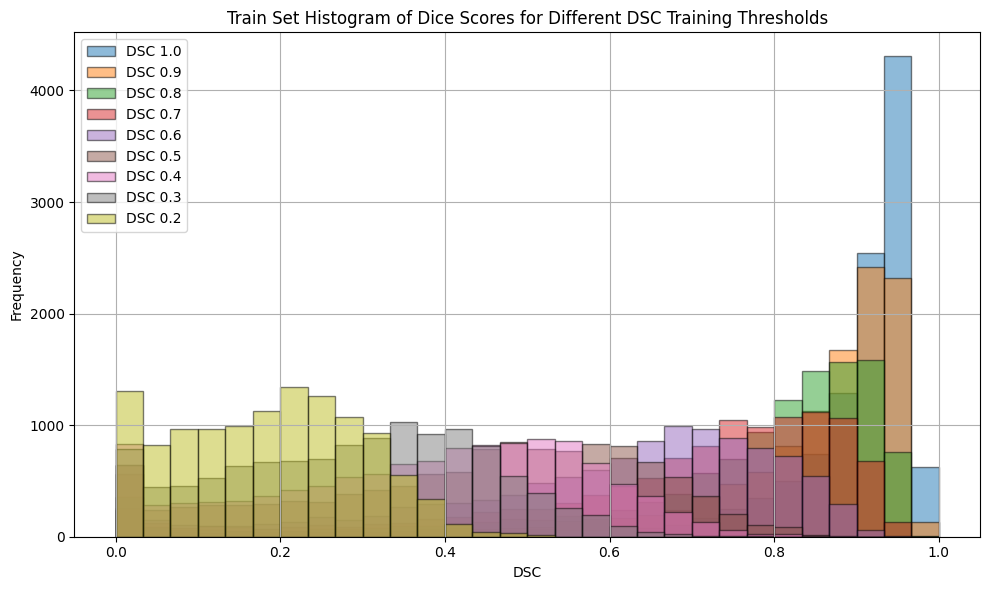

In [44]:
# Range of DSC thresholds
dsc_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Prepare plot
plt.figure(figsize=(10, 6))

data = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0_continued/results.csv")
case_number = data.case
slice_idx = data.slice

data_filtered = data[data["case"] > 20]
dsc_values = data_filtered["dsc"]
plt.hist(dsc_values, bins=30, range=(0, 1), alpha=0.5, label=f"DSC {1:.1f}", edgecolor='black')

for dsc in dsc_thresholds:
    model_name = f"qcKidneyDsc{dsc:.1f}Continued"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if not csv_path.exists():
        model_name = f"qcKidneyDsc{dsc:.1f}"
        csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
        
    data = pd.read_csv(csv_path)
    data_filtered = data[data["case"] > 20]
    dsc_values = data_filtered["dsc"]
    #data = pd.read_csv(csv_path)
    #dsc_values = data['dsc']
    
    plt.hist(dsc_values, bins=30, range=(0, 1), alpha=0.5, label=f"DSC {1-dsc:.1f}", edgecolor='black')

    print(f"Mean DSC for {model_name}: {np.mean(dsc_values):.4f}")


# Plot formatting
plt.xlabel("DSC")
plt.ylabel("Frequency")
plt.title("Train Set Histogram of Dice Scores for Different DSC Training Thresholds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean DSC for qcKidneyDsc0.8Continued: 0.1866


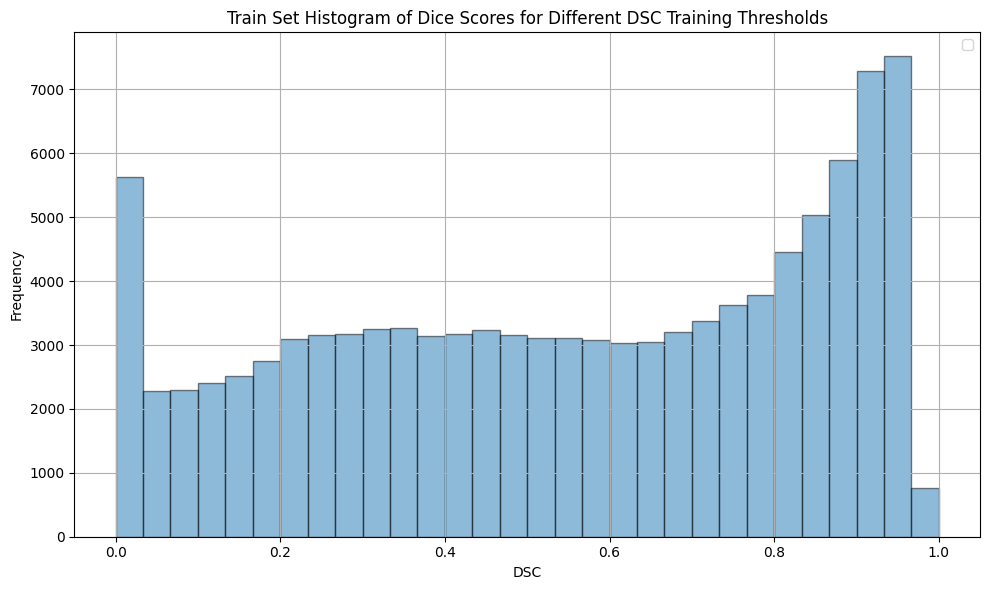

In [48]:
# Range of DSC thresholds
dsc_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Prepare plot
plt.figure(figsize=(10, 6))
all = np.array([])
data = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0_continued/results.csv")
case_number = data.case
slice_idx = data.slice

data_filtered = data[data["case"] > 20]
dsc_values = data_filtered["dsc"]
all = np.concatenate((all,dsc_values),axis=0)
for dsc in dsc_thresholds:
    model_name = f"qcKidneyDsc{dsc:.1f}Continued"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if not csv_path.exists():
        model_name = f"qcKidneyDsc{dsc:.1f}"
        csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
        
    data = pd.read_csv(csv_path)
    data_filtered = data[data["case"] > 20]
    dsc_values = data_filtered["dsc"]
    all = np.concatenate((all,dsc_values),axis=0)
    #data = pd.read_csv(csv_path)
    #dsc_values = data['dsc']
    
plt.hist(all, bins=30, range=(0, 1), alpha=0.5, edgecolor='black')

print(f"Mean DSC for {model_name}: {np.mean(dsc_values):.4f}")


# Plot formatting
plt.xlabel("DSC")
plt.ylabel("Frequency")
plt.title("Train Set Histogram of Dice Scores for Different DSC Training Thresholds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Mean DSC for qcKidneyDsc0.8Continued: 0.1866


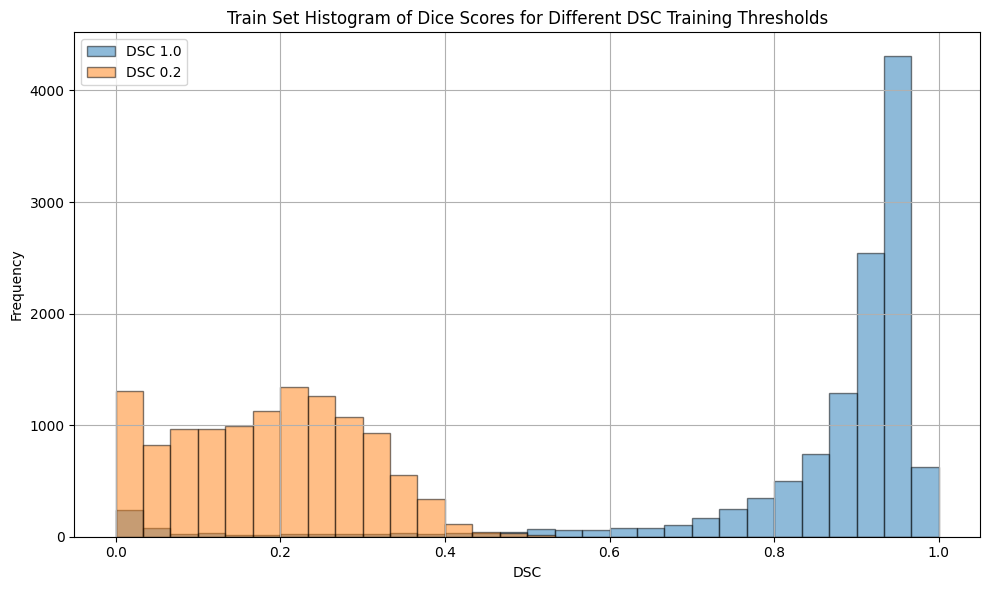

In [45]:
# Range of DSC thresholds
dsc_thresholds = [0.8]

# Prepare plot
plt.figure(figsize=(10, 6))

data = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0_continued/results.csv")
case_number = data.case
slice_idx = data.slice

data_filtered = data[data["case"] > 20]
dsc_values = data_filtered["dsc"]
plt.hist(dsc_values, bins=30, range=(0, 1), alpha=0.5, label=f"DSC {1:.1f}", edgecolor='black')

for dsc in dsc_thresholds:
    model_name = f"qcKidneyDsc{dsc:.1f}Continued"
    csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
    
    if not csv_path.exists():
        model_name = f"qcKidneyDsc{dsc:.1f}"
        csv_path = Path(f"/work3/kvabo/predictions/{model_name}/results.csv")
        
    data = pd.read_csv(csv_path)
    data_filtered = data[data["case"] > 20]
    dsc_values = data_filtered["dsc"]
    #data = pd.read_csv(csv_path)
    #dsc_values = data['dsc']
    
    plt.hist(dsc_values, bins=30, range=(0, 1), alpha=0.5, label=f"DSC {1-dsc:.1f}", edgecolor='black')

    print(f"Mean DSC for {model_name}: {np.mean(dsc_values):.4f}")


# Plot formatting
plt.xlabel("DSC")
plt.ylabel("Frequency")
plt.title("Train Set Histogram of Dice Scores for Different DSC Training Thresholds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

0.8592581449439796


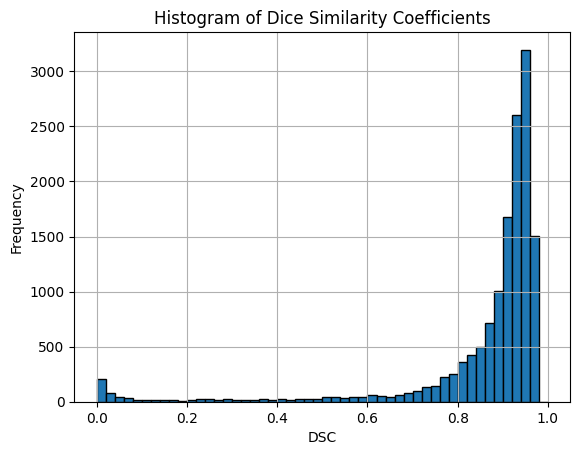

In [94]:
qcData = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0_continued/results.csv")
case_number = qcData.case
slice_idx = qcData.slice
dsc = qcData.dsc
plt.hist(dsc, bins=50, range=(0, 1), edgecolor='black')
print(np.mean(dsc))
plt.xlabel('DSC')
plt.ylabel('Frequency')
plt.title('Histogram of Dice Similarity Coefficients')
plt.grid(True)
plt.show()

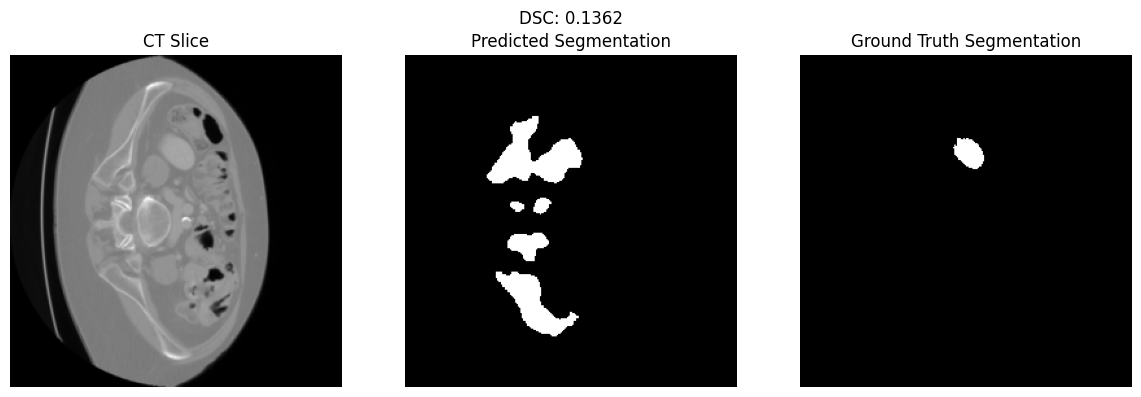

In [65]:
n = 2
target_class = 4

# Load prediction
segPath = Path(f"/work3/kvabo/predictions/qcKidneyDsc0.5Continued/{case_number[n]}_slice_{slice_idx[n]}_pred.npy")
seg = np.load(segPath)

# Load CT slice
ctPath = dir / f"volume-{case_number[n]}.npy"
ct = np.load(ctPath)[:, :, slice_idx[n]]

# Resize CT
ct = Image.fromarray(ct).convert("F")
ct = TF.resize(ct, (256, 256))
ct = np.array(ct, dtype=np.float32)

# Stack into tensor
X = np.stack([ct, seg], axis=0).astype(np.float32)
X = torch.tensor(X).unsqueeze(0)

# Load and resize ground truth
gt_path = dir / f"labels-{case_number[n]}.npy"
gt_full = np.load(gt_path)
gt = (gt_full[:, :, slice_idx[n]] == target_class).astype(np.uint8)
gt_tensor = torch.tensor(gt).unsqueeze(0).float()
gt_resized = TF.resize(gt_tensor, (256, 256)).squeeze().numpy().astype(np.uint8)

# Plot side by side
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(X[0][0].detach().cpu().numpy(), cmap='gray')
axs[0].set_title("CT Slice")
axs[0].axis('off')

axs[1].imshow(X[0][1].detach().cpu().numpy(), cmap='gray')
axs[1].set_title("Predicted Segmentation")
axs[1].axis('off')

axs[2].imshow(gt_resized, cmap='gray')
axs[2].set_title("Ground Truth Segmentation")
axs[2].axis('off')

plt.suptitle(f"DSC: {dsc[n]:.4f}")
plt.tight_layout()
plt.show()

In [52]:
diceLoss = smp.losses.DiceLoss(mode='binary', from_logits=False, eps=1e-7, smooth = 1)
# Convert to proper shape: [B, C, H, W]
pred_tensor = X[0][1].unsqueeze(0).unsqueeze(0)  # shape: [1, 1, 256, 256]
gt_tensor = torch.tensor(gt_resized).unsqueeze(0).unsqueeze(0).float()  # shape: [1, 1, 256, 256]

# Compute Dice score as 1 - loss
dice_score = 1 - diceLoss(pred_tensor, gt_tensor)
print(f"Dice Similarity Coefficient: {dice_score.item():.4f}")

Dice Similarity Coefficient: 0.4260


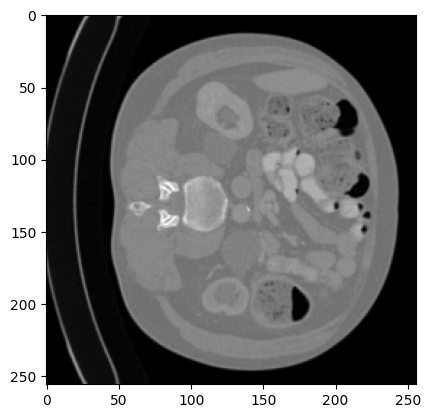

/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


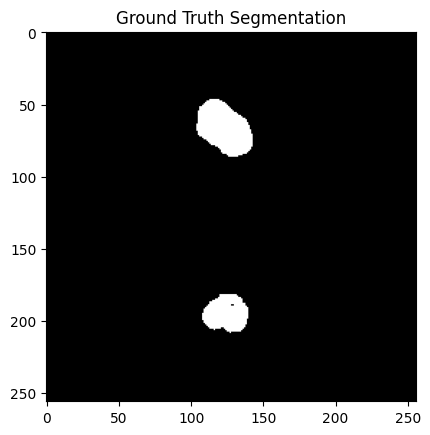

In [46]:
plt.imshow(X[0][0].detach().cpu().numpy(),cmap='gray')
plt.show()
target_class = 4
gt_path = dir / f"labels-{case_number[n]}.npy"
gt_full = np.load(gt_path)  # shape [H, W, D]
gt = (gt_full[:, :, slice_idx[n]] == target_class).astype(np.uint8)

        # Resize to match prediction size if needed
gt_tensor = torch.tensor(gt).unsqueeze(0).float()
gt_resized = TF.resize(gt_tensor, (256, 256)).squeeze().numpy().astype(np.uint8)

plt.imshow(gt_resized, cmap='gray')
plt.title("Ground Truth Segmentation")
plt.show()